In [1]:
import os
from typing import List
import json

import requests as requests
from typing import Union

from web3 import Web3, HTTPProvider

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")

In [3]:
ALCHEMY_API_KEY = os.environ['ALCHEMY_API_KEY']
web3 = Web3(HTTPProvider(f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}"))

In [4]:
pool_addr = "0xD51a44d3FaE010294C616388b506AcdA1bfAAE46"
pool_token_addr = "0xc4AD29ba4B3c580e6D59105FFf484999997675Ff"
lp_token_price_oracle_addr = "0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950"
with open("./tricrypto2.json", 'r') as f:
    abi = json.load(f)
with open("./3crvcrypto_oracle.json", 'r') as f:
    abi_oracle = json.load(f)
contract = web3.eth.contract(address=pool_addr, abi=abi)
oracle = web3.eth.contract(address=lp_token_price_oracle_addr, abi=abi_oracle)

In [5]:
pool_token_addr.lower()

'0xc4ad29ba4b3c580e6d59105fff484999997675ff'

In [6]:
url = "https://api.thegraph.com/subgraphs/name/convex-community/crv-emissions"
# needs pool token addr and not pool addr:
query = '''
{
  poolSnapshots (
    where:{
      pool: "0xc4ad29ba4b3c580e6d59105fff484999997675ff"
    }
  )
  {
    fees
    block
  }
}
'''
r = requests.post(url, json={'query': query})
dict_response= dict(r.json())
df_subgraph_pool_data = pd.DataFrame(dict_response['data']['poolSnapshots'])
df_subgraph_pool_data['block'] = df_subgraph_pool_data.block.astype(int)
df_subgraph_pool_data['fees'] = df_subgraph_pool_data.fees.astype(float)
df_subgraph_pool_data.index = df_subgraph_pool_data.block
df_subgraph_pool_data

,block,fees
block,,
12874992,12874992,0.000000
12917964,12917964,-26250.762708
12961965,12961965,24342.224780
13007147,13007147,60563.719539
13052446,13052446,166746.475245
13097719,13097719,194427.725807
13142950,13142950,177009.724078
13189474,13189474,381457.789816
13233504,13233504,304706.989145


In [7]:
blocks = list([int(i) for i in df_subgraph_pool_data.block.values])
block_ranges = list(zip(blocks, blocks[1:]))
block_ranges

[(12874992, 12917964),
 (12917964, 12961965),
 (12961965, 13007147),
 (13007147, 13052446),
 (13052446, 13097719),
 (13097719, 13142950),
 (13142950, 13189474),
 (13189474, 13233504),
 (13233504, 13279324),
 (13279324, 13324114),
 (13324114, 13368595),
 (13368595, 13413314),
 (13413314, 13458926),
 (13458926, 13509655),
 (13509655, 13549403),
 (13549403, 13592432)]

In [8]:
admin_fee_claims = []
for (block_start, block_end) in block_ranges:

    # swaps:
    event_filter = contract.events.ClaimAdminFee.createFilter(
        fromBlock=block_start,
        toBlock=block_end
    )
    claim_admin_fee_events = event_filter.get_all_entries()
    for event in claim_admin_fee_events:
        tokens_claimed = event['args']['tokens'] * 1e-18
        block = event['blockNumber']

        admin_fee_claims.append(
            {
                'block': block,
                'tokens_claimed': tokens_claimed,
            }
        )


In [9]:
df_admin_fee_claims = pd.DataFrame(admin_fee_claims)
df_admin_fee_claims

,block,tokens_claimed
0,12890377,3.996017
1,12891715,0.232722
2,12900847,2.026368
3,12902512,0.456430
4,12902614,0.007752
...,...,...
212,13566044,6.346029
213,13572493,3.660431
214,13578840,7.479940
215,13585216,5.830637


Now need to query prices using oracle.

In [10]:
from utils.contract_utils import init_contract
from utils.network_utils import configure_network_and_connect

In [11]:
configure_network_and_connect(
    node_provider_https=f"https://eth-mainnet.alchemyapi.io/v2/{ALCHEMY_API_KEY}",
    network_name='mainnet'
)

In [12]:
tricrypto2_lp_token_price_contract_address = "0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950"
contract_genesis = 12821148
tricrypto2_lp_token_price_contract = init_contract(tricrypto2_lp_token_price_contract_address)
tricrypto2_lp_token_price_contract

<Vyper_contract Contract '0xE8b2989276E2Ca8FDEA2268E3551b2b4B2418950'>

In [13]:
df_admin_fee_claims['oracle_price'] = 0
for idx, row in df_admin_fee_claims.iterrows():
    df_admin_fee_claims.loc[idx, 'oracle_price'] = 0
    try:
        oracle_price = (
            tricrypto2_lp_token_price_contract.lp_price(block_identifier=int(row.block))
        )
        df_admin_fee_claims.loc[idx, 'oracle_price'] = oracle_price * 1e-18
    except:
        continue
df_admin_fee_claims

,block,tokens_claimed,oracle_price
0,12890377,3.996017,0.000000
1,12891715,0.232722,0.000000
2,12900847,2.026368,0.000000
3,12902512,0.456430,0.000000
4,12902614,0.007752,0.000000
...,...,...,...
212,13566044,6.346029,1959.855532
213,13572493,3.660431,1993.954618
214,13578840,7.479940,2057.366708
215,13585216,5.830637,2059.951557


In [17]:
df_admin_fee_claims['total_claimed'] = df_admin_fee_claims.tokens_claimed * df_admin_fee_claims.oracle_price
df_admin_fee_claims

,block,tokens_claimed,oracle_price,total_claimed
0,12890377,3.996017,0.000000,0.000000
1,12891715,0.232722,0.000000,0.000000
2,12900847,2.026368,0.000000,0.000000
3,12902512,0.456430,0.000000,0.000000
4,12902614,0.007752,0.000000,0.000000
...,...,...,...,...
212,13566044,6.346029,1959.855532,12437.300190
213,13572493,3.660431,1993.954618,7298.732373
214,13578840,7.479940,2057.366708,15388.979706
215,13585216,5.830637,2059.951557,12010.829399


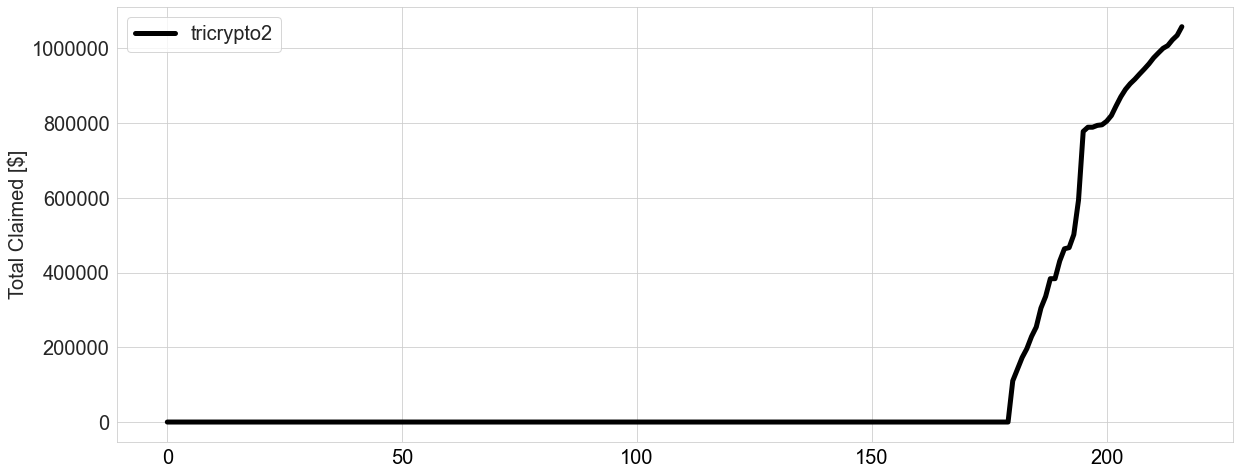

In [19]:
fig, ax = plt.subplots(1,1, figsize=(20, 8))

ax.plot(
    df_admin_fee_claims.index,
    df_admin_fee_claims.total_claimed.cumsum(),
    color='black',
    lw=5,
    label='tricrypto2'
)
ax.set_ylabel("Total Claimed [$]", fontsize=20)
ax.tick_params(axis='both', which='major', labelsize=20)
ax.tick_params(axis='x', which='major', colors='black')
ax.legend(fontsize=20)
ax.yaxis.get_major_formatter().set_scientific(False)
ax.yaxis.get_major_formatter().set_useOffset(False)